# Model evaluation notebook

in this notebook we will evaluate % availability. definitions are:

X = 
    location: site_id
    time: hour, dow, weekend, is_holiday, 
    weather: temperature, dew point, relative humidity, wind direction, wind speed
    grid: net demand, solar, wind
y = % available (for site)

this will work for all sites.

How will we do train test split?
random 80-20 for now 


In [1]:
import os
if 'models' == os.getcwd().split('/')[-1]: os.chdir('..')
if 'ev_charging' == os.getcwd().split('/')[-1]: print('in the right place!')
else: os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

in the right place!


'/home/denny/Documents/mids/ev_charging'

In [2]:
import pandas as pd
from src.weather import get_processed_hourly_7day_weather


# Get historical weather

In [3]:
historical_weather = pd.DataFrame({})
weather_features = ['temperature_degC', 'dewpoint_degC','relative_humidity_%', 'wind_speed_mph']
hist_weather = pd.read_csv('./data/caltech_historical_weather.csv').set_index('time')[weather_features]
hist_weather['site'] = 'Caltech'
if historical_weather.empty: 
    historical_weather = hist_weather
else:
    historical_weather = pd.concat([historical_weather, hist_weather], axis=0)

In [4]:
weather_features = ['temperature_degC', 'dewpoint_degC','relative_humidity_%', 'wind_speed_mph']
hist_weather = pd.read_csv('./data/caltech_historical_weather.csv').set_index('time')[weather_features]
hist_weather['site'] = 'JPL'
if historical_weather.empty: 
    historical_weather = hist_weather
else:
    historical_weather = pd.concat([historical_weather, hist_weather], axis=0)

In [5]:
weather_features = ['temperature_degC', 'dewpoint_degC','relative_humidity_%', 'wind_speed_mph']
hist_weather = pd.read_csv('./data/office_historical_weather.csv').set_index('time')[weather_features]
hist_weather['site'] = 'Office001'
if historical_weather.empty: 
    historical_weather = hist_weather
else:
    historical_weather = pd.concat([historical_weather, hist_weather], axis=0)

In [6]:
historical_weather.index = pd.to_datetime(historical_weather.index).tz_localize('UTC-07:00')

In [7]:
# historical_weather.site.unique()
historical_weather.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97416 entries, 0 to 97415
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   time                 97416 non-null  datetime64[ns, UTC-07:00]
 1   temperature_degC     97408 non-null  float64                  
 2   dewpoint_degC        97405 non-null  float64                  
 3   relative_humidity_%  97405 non-null  float64                  
 4   wind_speed_mph       97407 non-null  float64                  
 5   site                 97416 non-null  object                   
dtypes: datetime64[ns, UTC-07:00](1), float64(4), object(1)
memory usage: 4.5+ MB


# get future weather

In [8]:
from src.weather import get_processed_hourly_7day_weather
site2latlon = {'Caltech':(34.134785646454844, -118.11691382579643),
               'Office001':(37.33680466796926, -121.90743423142634),
               'JPL':(34.20142342818471, -118.17126565774107)}
future_weather = get_processed_hourly_7day_weather(*site2latlon['Caltech'])

https://api.weather.gov/points/34.134785646454844,-118.11691382579643
status code: 200
https://api.weather.gov/gridpoints/LOX/160,48/forecast/hourly


In [9]:
# save if needed
future_weather.to_csv('data/test_future_weather.csv')

 confirm that past and future weather have the same features

In [10]:
print(f'future weather features are \n{list(future_weather[weather_features].columns)}, \nand historical weather features are \n{list(hist_weather[weather_features].columns)}')

future weather features are 
['temperature_degC', 'dewpoint_degC', 'relative_humidity_%', 'wind_speed_mph'], 
and historical weather features are 
['temperature_degC', 'dewpoint_degC', 'relative_humidity_%', 'wind_speed_mph']


# get caiso data

In [11]:
from src import oasis
import datetime
import pandas as pd
from src.oasis import SystemDemand
import urllib
import datetime
sd = SystemDemand()

In [12]:
start = datetime.datetime(2024,4,8)
end = datetime.datetime(2024,4,9)
demand_forecast = sd.get_demand_forecast(start, end)

In [13]:
demand_forecast.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16693 entries, 0 to 16692
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   index                  16693 non-null  int64  
 1   INTERVALSTARTTIME_GMT  16693 non-null  object 
 2   INTERVALENDTIME_GMT    16693 non-null  object 
 3   LOAD_TYPE              16693 non-null  int64  
 4   OPR_DT                 16693 non-null  object 
 5   OPR_HR                 16693 non-null  int64  
 6   OPR_INTERVAL           16693 non-null  int64  
 7   MARKET_RUN_ID          16693 non-null  object 
 8   TAC_AREA_NAME          16693 non-null  object 
 9   LABEL                  16693 non-null  object 
 10  XML_DATA_ITEM          16693 non-null  object 
 11  POS                    16693 non-null  float64
 12  MW                     16693 non-null  float64
 13  EXECUTION_TYPE         16693 non-null  object 
 14  GROUP                  16693 non-null  int64  
dtypes:

# Get historical demand

the data from the request is the bytes for a zip file. to get it to a pandas dataframe,
1. read the content with the io.BytesIO
2. open the bytes as a zip file with ZipFile
3. open the zip file by getting the first (and only) name in the extraction
4. read the data using the .read() method of the file object
5. convert the raw data to a string with BytesIO again
6. read the bytes to a dataframe with the pd.read_csv file

In [14]:
historical_caiso_actual_load = pd.read_csv('data/historical_caiso_actual_load.csv', index_col=[0])

In [15]:
TACS = ['SCE-TAC', 'PGE-TAC']
MARKET_RUN_IDS = ['ACTUAL']

In [16]:
historical_caiso_actual_load['datetime'] = pd.to_datetime(historical_caiso_actual_load['OPR_DT']) + pd.to_timedelta(historical_caiso_actual_load['OPR_HR'], unit='h')
historical_caiso_actual_load = historical_caiso_actual_load[
    (historical_caiso_actual_load['TAC_AREA_NAME'].isin(TACS)) &
    (historical_caiso_actual_load['MARKET_RUN_ID'].isin(MARKET_RUN_IDS))
]

In [17]:

demand_forecast['datetime'] = pd.to_datetime(demand_forecast['OPR_DT']) + pd.to_timedelta(demand_forecast['OPR_HR'], unit='h')
demand_forecast = demand_forecast[
    (demand_forecast['TAC_AREA_NAME'].isin(TACS)) &
    (demand_forecast['MARKET_RUN_ID'].isin(MARKET_RUN_IDS))
]

In [18]:
demand_features = ['datetime', 'TAC_AREA_NAME', 'MARKET_RUN_ID', 'MW']

In [19]:
demand_forecast[demand_features].columns == historical_caiso_actual_load[demand_features].columns

array([ True,  True,  True,  True])

In [20]:
demand_forecast.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  48 non-null     int64         
 1   INTERVALSTARTTIME_GMT  48 non-null     object        
 2   INTERVALENDTIME_GMT    48 non-null     object        
 3   LOAD_TYPE              48 non-null     int64         
 4   OPR_DT                 48 non-null     object        
 5   OPR_HR                 48 non-null     int64         
 6   OPR_INTERVAL           48 non-null     int64         
 7   MARKET_RUN_ID          48 non-null     object        
 8   TAC_AREA_NAME          48 non-null     object        
 9   LABEL                  48 non-null     object        
 10  XML_DATA_ITEM          48 non-null     object        
 11  POS                    48 non-null     float64       
 12  MW                     48 non-null     float64       
 13  EXECUTI

# Modeling

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from datetime import datetime

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from src.data_preprocessing import  datetime_processing, userinput_processing, holiday_processing, create_all_site_x, create_all_site_y, create_x, update_varuns_x, get_start_end_times

In [22]:
df_c = pd.read_parquet('data/sessions/caltech/').reset_index(drop=True)
df_c = datetime_processing(df_c)
df_c = userinput_processing(df_c)

df_j = pd.read_parquet('data/sessions/jpl/').reset_index(drop=True)
df_j = datetime_processing(df_j)
df_j = userinput_processing(df_j)

df_o = pd.read_parquet('data/sessions/office001/').reset_index(drop=True)
df_o = datetime_processing(df_o)
df_o = userinput_processing(df_o)

cols = list(df_c.columns)
df = pd.concat([df_c[cols], df_j[cols], df_o[cols]], axis=0)

In [23]:
print(f'df is a dataframe comprised of these site ids: {list(df.siteID.unique())}')

df is a dataframe comprised of these site ids: [2, 1, 19]


# Make X and y

X contains 4 different sets of data - location, datetime, weather, energy demand

In [24]:
X = pd.DataFrame()
sites_df = [df_o,df_c,df_j]
sites = ['Office001','Caltech','JPL']
site_ids = [2,1,19]
site2id = { k:v for (k,v) in zip(sites, site_ids)}
site2tac = {2:'PGE-TAC',
            1:'SCE-TAC',
            19:'SCE-TAC',
            }
    

In [25]:
X = pd.DataFrame()
for sdf, id, site_name in zip(sites_df, site_ids, sites):
    start, end = get_start_end_times(sdf)
    print(site_name, start, end)
    # time
    x = pd.DataFrame(index=pd.date_range(start, end, inclusive='both', freq='h', tz='UTC-07:00'),
                     columns=['dow', 'hour', 'month'])
    x['dow'] = x.index.dayofweek
    x['hour'] = x.index.hour
    x['month'] = x.index.month
    
    x = holiday_processing(x)
    
    # print('x rows: ', x.shape[0])
    # energy demand
    demand = historical_caiso_actual_load[demand_features].set_index('datetime').rename(columns={'MW':'actual_demand_MW'}).sort_index()
    demand = demand[demand['TAC_AREA_NAME'] == site2tac[id]][['actual_demand_MW']]
    demand.index = pd.to_datetime(demand.index).tz_localize('UTC-07:00')
    demand = demand.loc[x.index.min():x.index.max(),:]
    # print('dem rows', demand.shape[0])
    
    x = pd.merge(x,demand, left_index=True, right_index=True, how='left')
    
    # weather and location
    weather = historical_weather[historical_weather['site']==site_name]
    weather = weather.loc[x.index.min():x.index.max(), :]
    # print('weather rows:', weather.shape[0])
    x = pd.merge(x, weather, left_index=True, right_index=True, how='left')
    # print('together rows: ', x.shape[0])
    if X.empty:
        X = x
    else:
        X = pd.concat([X, x], axis=0)

X.head()

Office001 2019-03-25 2021-09-12
Caltech 2018-05-01 2021-09-14
JPL 2018-09-05 2021-09-13


,dow,hour,month,is_holiday,actual_demand_MW,temperature_degC,dewpoint_degC,relative_humidity_%,wind_speed_mph,site
2019-03-25 00:00:00-07:00,0,0,3,False,9470.0,18.9,-1.6,25.0,9.20,Office001
2019-03-25 01:00:00-07:00,0,1,3,False,9036.0,19.4,-1.7,24.0,6.96,Office001
2019-03-25 02:00:00-07:00,0,2,3,False,8963.0,15.0,-2.0,31.0,14.98,Office001
2019-03-25 03:00:00-07:00,0,3,3,False,8818.0,13.3,-2.2,34.0,10.31,Office001
2019-03-25 04:00:00-07:00,0,4,3,False,8840.0,13.3,-1.9,35.0,0.00,Office001


We've introduced duplicates based on daylight savings. Remove them

In [26]:
X.reset_index()[['index','site']].value_counts().head(7)

index                      site     
2019-11-04 01:00:00-07:00  JPL          2
                           Caltech      2
2018-11-05 01:00:00-07:00  Caltech      2
                           JPL          2
2019-11-04 01:00:00-07:00  Office001    2
2020-09-18 07:00:00-07:00  Office001    1
                           JPL          1
Name: count, dtype: int64

In [27]:
print('with duplicates:    ', X.shape[0])
print('without duplicates: ', X['site'].reset_index().drop_duplicates(subset=['index','site']).shape[0])


with duplicates:     77720
without duplicates:  77715


In [28]:
X = X.reset_index().drop_duplicates(subset=['index', 'site']).set_index('index')
X.shape
# X.set_index('site')

(77715, 10)

however, we did not have missing values in march for spring ahead (or maybe we did, but left join kept us a record)

In [29]:
X.reset_index()[['index','site']].value_counts().tail(4)

index                      site     
2019-09-24 10:00:00-07:00  JPL          1
                           Caltech      1
2019-09-24 09:00:00-07:00  Office001    1
2021-09-14 00:00:00-07:00  Caltech      1
Name: count, dtype: int64

In [30]:
X[(X.index < '2020-03-01') & (X['actual_demand_MW'].isnull())]

,dow,hour,month,is_holiday,actual_demand_MW,temperature_degC,dewpoint_degC,relative_humidity_%,wind_speed_mph,site
index,,,,,,,,,,
2019-03-10 03:00:00-07:00,6,3,3,False,NaN,11.2,3.0,57.0,9.2,Caltech
2019-03-10 03:00:00-07:00,6,3,3,False,NaN,11.2,3.0,57.0,9.2,JPL


# impute march values

In [31]:
# at 2 AM, the demand for Caltech and JPL was 9133. Use it for 3 AM
X.loc['2019-03-10 03:00:00', 'actual_demand_MW'] = 9133

In [32]:
X.loc['2019-03-10 03:00:00', 'actual_demand_MW']

index
2019-03-10 03:00:00-07:00    9133.0
2019-03-10 03:00:00-07:00    9133.0
Name: actual_demand_MW, dtype: float64

In [33]:
X['site'].value_counts().sum() == X.shape[0]
print(f'there are {X.shape[0]} records')

there are 77715 records


In [34]:
X['site'].value_counts()

site
Caltech      29569
JPL          26497
Office001    21649
Name: count, dtype: int64

# Deal with covid
we found (graphically) that covid effects start around march 3rd 2020, so we truncated our data to march 1st. Since we did not have dates that contained post covid data, we did not include any charges after 2020-03-01 

In [35]:
x = X[X.index < '2020-03-01']
X.index.max()


Timestamp('2021-09-14 00:00:00-0700', tz='UTC-07:00')

In [36]:
cols = list(df_c.columns)
df = pd.concat([df[cols] for df in sites_df], axis=0)
y = create_all_site_y(df, regression=True)

In [37]:
assert X.shape[0] == y.shape[0], 'X and y rows are not equal!, X shape = {} y shape {}'.format(X.shape, y.shape)

In [38]:
y = y[y.index < '2020-03-01']
y.index.max()
y.shape

(37320,)

In [39]:
assert x.shape[0] == y.shape[0], 'forgot to trim y\'s covid!'

# XGBoost

In [40]:
X.columns

Index(['dow', 'hour', 'month', 'is_holiday', 'actual_demand_MW',
       'temperature_degC', 'dewpoint_degC', 'relative_humidity_%',
       'wind_speed_mph', 'site'],
      dtype='object')

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_holiday','site']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


xgb_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('xgb', XGBRegressor()),
        ]
)

xgb_model.fit(X_train, y_train)
print(f'training RMSE: {np.sqrt(mean_squared_error(xgb_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(xgb_model.predict(X_test), y_test))}')
print(f'training r2: {xgb_model.score(X_train, y_train)}\ntest r2    : {xgb_model.score(X_test, y_test)}')

training RMSE: 0.10096841443217164
test RMSE    : 0.11612157064051419
training r2: 0.8735515546606845
test r2    : 0.8266423989843182


Text(0, 0.5, '% available')

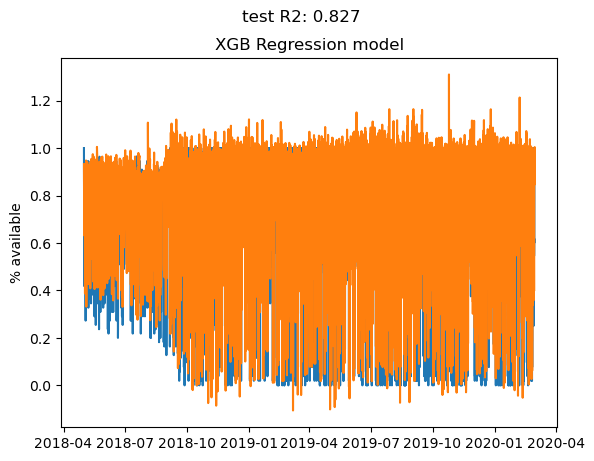

In [42]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(xgb_model.predict(X_test), index=X_test.index)
plt.title('XGB Regression model')
plt.suptitle(f'test R2: {np.round(xgb_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

In [43]:
import pickle
pickle.dump(xgb_model, open('./model_04_10.pkl','wb'))
os.getcwd()

'/home/denny/Documents/mids/ev_charging'

# feature importance

In [44]:
col_names = xgb_model.named_steps['preprocessing'].get_feature_names_out()
model = xgb_model.named_steps['xgb']
# https://stackoverflow.com/a/74967040/6432367
model.get_booster().feature_names = list(col_names)
feature_importance = model.get_booster().get_score()

Text(0.5, 1.0, 'Feature importance by gain: ‘gain’ - the average gain across all splits the feature is used in.')

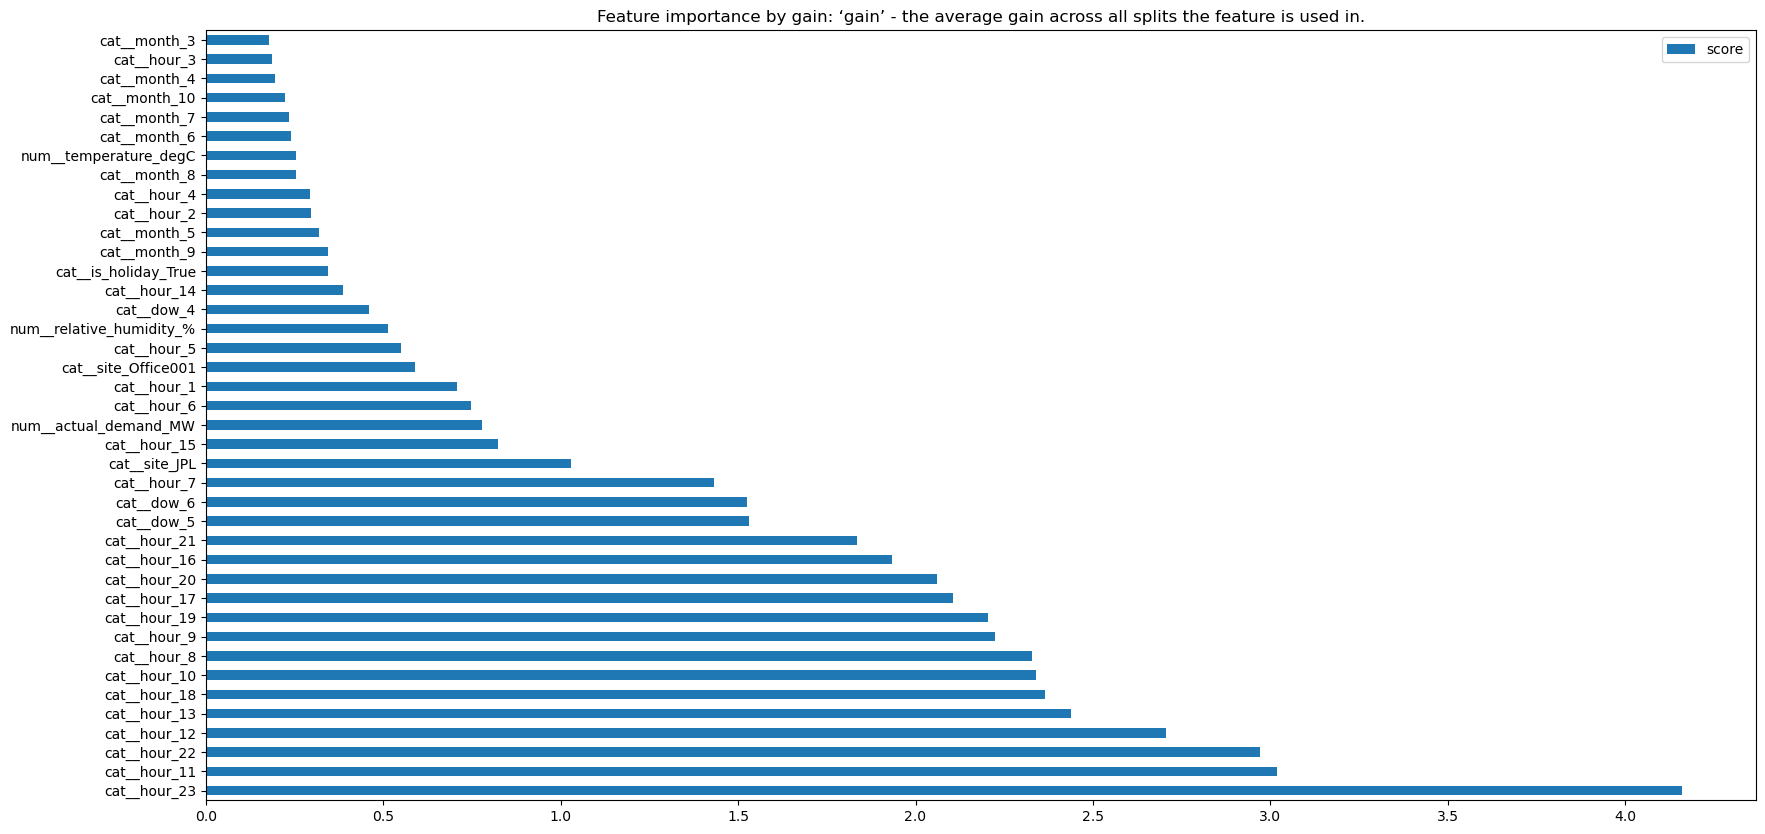

In [45]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
plt.title('Feature importance by gain: ‘gain’ - the average gain across all splits the feature is used in.')
# plt.title('Feature importance by weight: ‘weight’ - the number of times a feature is used to split the data across all trees.')

# Inference example

In [46]:
import pandas as pd
sites = ['Office001','Caltech','JPL']
site_ids = [2,1,19]
site2id = { k:v for (k,v) in zip(sites, site_ids)}
site2tac = {2:'PGE-TAC', 1:'SCE-TAC', 19:'SCE-TAC',}
weather_features = ['temperature_degC', 'dewpoint_degC','relative_humidity_%', 'wind_speed_mph']
demand_features = ['datetime', 'TAC_AREA_NAME', 'MARKET_RUN_ID', 'MW']

In [47]:
# columns_needed
X_train.columns

Index(['dow', 'hour', 'month', 'is_holiday', 'actual_demand_MW',
       'temperature_degC', 'dewpoint_degC', 'relative_humidity_%',
       'wind_speed_mph', 'site'],
      dtype='object')

# future weather

In [48]:
from src.weather import get_processed_hourly_7day_weather
site2latlon = {'Caltech':(34.134785646454844, -118.11691382579643),
               'Office001':(37.33680466796926, -121.90743423142634),
               'JPL':(34.20142342818471, -118.17126565774107)}
future_weather = pd.DataFrame()
for site in sites:
    tmp_future_weather = get_processed_hourly_7day_weather(*site2latlon[site])
    tmp_future_weather['site'] = site
    if future_weather.empty:
        future_weather = tmp_future_weather
    else:
        future_weather = pd.concat([future_weather, tmp_future_weather], axis=0)

https://api.weather.gov/points/37.33680466796926,-121.90743423142634
status code: 200
https://api.weather.gov/gridpoints/MTR/99,82/forecast/hourly
https://api.weather.gov/points/34.134785646454844,-118.11691382579643
status code: 200
https://api.weather.gov/gridpoints/LOX/160,48/forecast/hourly
https://api.weather.gov/points/34.20142342818471,-118.17126565774107
status code: 200
https://api.weather.gov/gridpoints/LOX/159,51/forecast/hourly


In [49]:
future_weather = future_weather[weather_features + ['site']]
future_weather.head()

,temperature_degC,dewpoint_degC,relative_humidity_%,wind_speed_mph,site
time,,,,,
2024-04-09 23:00:00-07:00,13.89,10.00,76,2,Office001
2024-04-10 00:00:00-07:00,12.78,10.00,81,2,Office001
2024-04-10 01:00:00-07:00,11.67,8.89,83,2,Office001
2024-04-10 02:00:00-07:00,11.11,8.33,84,2,Office001
2024-04-10 03:00:00-07:00,10.56,8.33,86,2,Office001


In [50]:
future_weather[future_weather['site'] == 'JPL'].reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype                    
---  ------               --------------  -----                    
 0   time                 156 non-null    datetime64[ns, UTC-07:00]
 1   temperature_degC     156 non-null    float64                  
 2   dewpoint_degC        156 non-null    float64                  
 3   relative_humidity_%  156 non-null    int64                    
 4   wind_speed_mph       156 non-null    int64                    
 5   site                 156 non-null    object                   
dtypes: datetime64[ns, UTC-07:00](1), float64(2), int64(2), object(1)
memory usage: 7.4+ KB


# future demand

In [51]:
import pytz
# pytz.common_timezones

In [52]:
from src.oasis import SystemDemand
import datetime

sd = SystemDemand()
start = datetime.datetime.today()
end = start + pd.to_timedelta(7, unit='d')
demand_forecast = sd.get_demand_forecast(start, end)

TACS = ['SCE-TAC', 'PGE-TAC']
MARKET_RUN_IDS = ['ACTUAL']
demand_forecast['datetime'] = pd.to_datetime(demand_forecast['OPR_DT']) + pd.to_timedelta(demand_forecast['OPR_HR'], unit='h')
demand_forecast = demand_forecast[
    (demand_forecast['TAC_AREA_NAME'].isin(TACS)) 
    & (demand_forecast['MARKET_RUN_ID'].isin(['7DA']))
]

# demand = historical_caiso_actual_load[demand_features].set_index('datetime').rename(columns={'MW':'actual_demand_MW'}).sort_index()
# demand = demand[demand['TAC_AREA_NAME'] == site2tac[id]][['actual_demand_MW']]
# demand.index = pd.to_datetime(demand.index, utc=True)

In [53]:
demand_forecast

,INTERVALSTARTTIME_GMT,INTERVALENDTIME_GMT,LOAD_TYPE,OPR_DT,OPR_HR,OPR_INTERVAL,MARKET_RUN_ID,TAC_AREA_NAME,LABEL,XML_DATA_ITEM,POS,MW,EXECUTION_TYPE,GROUP,datetime
1242,2024-04-10T18:00:00-00:00,2024-04-10T19:00:00-00:00,0,2024-04-10,12,0,7DA,PGE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.1,7329.97,7DA,55,2024-04-10 12:00:00
1243,2024-04-10T19:00:00-00:00,2024-04-10T20:00:00-00:00,0,2024-04-10,13,0,7DA,PGE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.1,7002.69,7DA,55,2024-04-10 13:00:00
1244,2024-04-10T21:00:00-00:00,2024-04-10T22:00:00-00:00,0,2024-04-10,15,0,7DA,PGE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.1,6987.50,7DA,55,2024-04-10 15:00:00
1245,2024-04-11T00:00:00-00:00,2024-04-11T01:00:00-00:00,0,2024-04-10,18,0,7DA,PGE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.1,9544.22,7DA,55,2024-04-10 18:00:00
1246,2024-04-10T12:00:00-00:00,2024-04-10T13:00:00-00:00,0,2024-04-10,6,0,7DA,PGE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.1,9929.14,7DA,55,2024-04-10 06:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7813,2024-04-16T20:00:00-00:00,2024-04-16T21:00:00-00:00,0,2024-04-16,14,0,7DA,SCE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.2,7834.10,7DA,330,2024-04-16 14:00:00
7814,2024-04-16T23:00:00-00:00,2024-04-17T00:00:00-00:00,0,2024-04-16,17,0,7DA,SCE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.2,8947.09,7DA,330,2024-04-16 17:00:00
7815,2024-04-17T00:00:00-00:00,2024-04-17T01:00:00-00:00,0,2024-04-16,18,0,7DA,SCE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.2,9685.99,7DA,330,2024-04-16 18:00:00
7816,2024-04-17T04:00:00-00:00,2024-04-17T05:00:00-00:00,0,2024-04-16,22,0,7DA,SCE-TAC,Demand Forecast 7-Day Ahead,SYS_FCST_7DA_MW,0.2,10914.48,7DA,330,2024-04-16 22:00:00


In [54]:
demand = pd.DataFrame({})
for site in sites:
    tmp_demand = demand_forecast.loc[demand_forecast['TAC_AREA_NAME'] == site2tac[site2id[site]], demand_features].set_index('datetime')

    tmp_demand['site'] = site
    
    tmp_demand.index = pd.to_datetime(tmp_demand.index)#.tz_localize('US/Pacific')

    if demand.empty:
        demand = tmp_demand
    else:
        demand = pd.concat([demand,tmp_demand], axis=0)
demand = demand.rename(columns={'MW':'actual_demand_MW'}).sort_index()
demand.index = demand.index.tz_localize('UTC-07:00')

In [55]:
demand

,TAC_AREA_NAME,MARKET_RUN_ID,actual_demand_MW,site
datetime,,,,
2024-04-10 02:00:00-07:00,PGE-TAC,7DA,9417.96,Office001
2024-04-10 02:00:00-07:00,SCE-TAC,7DA,8861.39,JPL
2024-04-10 02:00:00-07:00,SCE-TAC,7DA,8861.39,Caltech
2024-04-10 03:00:00-07:00,SCE-TAC,7DA,8619.08,JPL
2024-04-10 03:00:00-07:00,SCE-TAC,7DA,8619.08,Caltech
...,...,...,...,...
2024-04-16 23:00:00-07:00,PGE-TAC,7DA,10465.18,Office001
2024-04-16 23:00:00-07:00,SCE-TAC,7DA,10306.69,Caltech
2024-04-17 00:00:00-07:00,PGE-TAC,7DA,9789.17,Office001


In [56]:
demand.head()

,TAC_AREA_NAME,MARKET_RUN_ID,actual_demand_MW,site
datetime,,,,
2024-04-10 02:00:00-07:00,PGE-TAC,7DA,9417.96,Office001
2024-04-10 02:00:00-07:00,SCE-TAC,7DA,8861.39,JPL
2024-04-10 02:00:00-07:00,SCE-TAC,7DA,8861.39,Caltech
2024-04-10 03:00:00-07:00,SCE-TAC,7DA,8619.08,JPL
2024-04-10 03:00:00-07:00,SCE-TAC,7DA,8619.08,Caltech


# time features

In [57]:
from src.data_preprocessing import  datetime_processing, userinput_processing, holiday_processing, create_all_site_x, create_all_site_y, create_x, update_varuns_x, get_start_end_times
X = pd.DataFrame()
for site in sites:
    print(site, start, end)
    # time
    x = pd.DataFrame(index=pd.date_range(start.date(), end.date(), inclusive='both', freq='h', tz='UTC-07:00'),
                     columns=['dow', 'hour', 'month'])
    x['dow'] = x.index.dayofweek
    x['hour'] = x.index.hour
    x['month'] = x.index.month
    
    x = holiday_processing(x)
    x['site'] = site
    if X.empty:
        X = x
    else:
        X = pd.concat([X, x], axis=0)
        
X.head()

Office001 2024-04-10 00:58:56.756909 2024-04-17 00:58:56.756909
Caltech 2024-04-10 00:58:56.756909 2024-04-17 00:58:56.756909
JPL 2024-04-10 00:58:56.756909 2024-04-17 00:58:56.756909


,dow,hour,month,is_holiday,site
2024-04-10 00:00:00-07:00,2,0,4,False,Office001
2024-04-10 01:00:00-07:00,2,1,4,False,Office001
2024-04-10 02:00:00-07:00,2,2,4,False,Office001
2024-04-10 03:00:00-07:00,2,3,4,False,Office001
2024-04-10 04:00:00-07:00,2,4,4,False,Office001


In [58]:
X.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   index       507 non-null    datetime64[ns, UTC-07:00]
 1   dow         507 non-null    int32                    
 2   hour        507 non-null    int32                    
 3   month       507 non-null    int32                    
 4   is_holiday  507 non-null    bool                     
 5   site        507 non-null    object                   
dtypes: bool(1), datetime64[ns, UTC-07:00](1), int32(3), object(1)
memory usage: 14.5+ KB


In [59]:
demand.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype                    
---  ------            --------------  -----                    
 0   datetime          501 non-null    datetime64[ns, UTC-07:00]
 1   TAC_AREA_NAME     501 non-null    object                   
 2   MARKET_RUN_ID     501 non-null    object                   
 3   actual_demand_MW  501 non-null    float64                  
 4   site              501 non-null    object                   
dtypes: datetime64[ns, UTC-07:00](1), float64(1), object(3)
memory usage: 19.7+ KB


In [60]:
X.reset_index().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype                    
---  ------      --------------  -----                    
 0   index       507 non-null    datetime64[ns, UTC-07:00]
 1   dow         507 non-null    int32                    
 2   hour        507 non-null    int32                    
 3   month       507 non-null    int32                    
 4   is_holiday  507 non-null    bool                     
 5   site        507 non-null    object                   
dtypes: bool(1), datetime64[ns, UTC-07:00](1), int32(3), object(1)
memory usage: 14.5+ KB


In [61]:
tmp = pd.merge(X.reset_index(), demand.reset_index(), how='left', left_on=['index', 'site'], right_on=['datetime', 'site'])
tmp = pd.merge(tmp, future_weather.reset_index(), how='left', left_on=['index','site'], right_on=['time', 'site'])
tmp.set_index('index',inplace=True)
tmp

,dow,hour,month,is_holiday,site,datetime,TAC_AREA_NAME,MARKET_RUN_ID,actual_demand_MW,time,temperature_degC,dewpoint_degC,relative_humidity_%,wind_speed_mph
index,,,,,,,,,,,,,,
2024-04-10 00:00:00-07:00,2,0,4,False,Office001,NaT,NaN,NaN,NaN,2024-04-10 00:00:00-07:00,12.78,10.00,81.0,2.0
2024-04-10 01:00:00-07:00,2,1,4,False,Office001,NaT,NaN,NaN,NaN,2024-04-10 01:00:00-07:00,11.67,8.89,83.0,2.0
2024-04-10 02:00:00-07:00,2,2,4,False,Office001,2024-04-10 02:00:00-07:00,PGE-TAC,7DA,9417.96,2024-04-10 02:00:00-07:00,11.11,8.33,84.0,2.0
2024-04-10 03:00:00-07:00,2,3,4,False,Office001,2024-04-10 03:00:00-07:00,PGE-TAC,7DA,9173.07,2024-04-10 03:00:00-07:00,10.56,8.33,86.0,2.0
2024-04-10 04:00:00-07:00,2,4,4,False,Office001,2024-04-10 04:00:00-07:00,PGE-TAC,7DA,9118.30,2024-04-10 04:00:00-07:00,9.44,7.22,85.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16 20:00:00-07:00,1,20,4,False,JPL,2024-04-16 20:00:00-07:00,SCE-TAC,7DA,11042.32,NaT,NaN,NaN,NaN,NaN
2024-04-16 21:00:00-07:00,1,21,4,False,JPL,2024-04-16 21:00:00-07:00,SCE-TAC,7DA,11170.34,NaT,NaN,NaN,NaN,NaN
2024-04-16 22:00:00-07:00,1,22,4,False,JPL,2024-04-16 22:00:00-07:00,SCE-TAC,7DA,10914.48,NaT,NaN,NaN,NaN,NaN


In [62]:
features = ['dow', 'hour', 'month', 'is_holiday', 'actual_demand_MW',
       'temperature_degC', 'dewpoint_degC', 'relative_humidity_%',
       'wind_speed_mph', 'site']
tmp = tmp[features]

In [63]:
tmp[(~tmp['actual_demand_MW'].isnull()) & (~tmp['temperature_degC'].isnull())]

,dow,hour,month,is_holiday,actual_demand_MW,temperature_degC,dewpoint_degC,relative_humidity_%,wind_speed_mph,site
index,,,,,,,,,,
2024-04-10 02:00:00-07:00,2,2,4,False,9417.96,11.11,8.33,84.0,2.0,Office001
2024-04-10 03:00:00-07:00,2,3,4,False,9173.07,10.56,8.33,86.0,2.0,Office001
2024-04-10 04:00:00-07:00,2,4,4,False,9118.30,9.44,7.22,85.0,2.0,Office001
2024-04-10 05:00:00-07:00,2,5,4,False,9335.23,10.00,7.78,87.0,2.0,Office001
2024-04-10 06:00:00-07:00,2,6,4,False,9929.14,10.00,7.78,87.0,2.0,Office001
...,...,...,...,...,...,...,...,...,...,...
2024-04-16 06:00:00-07:00,1,6,4,False,9337.86,9.44,6.67,85.0,5.0,JPL
2024-04-16 07:00:00-07:00,1,7,4,False,9972.62,10.00,7.22,85.0,5.0,JPL
2024-04-16 08:00:00-07:00,1,8,4,False,9985.37,11.11,8.33,83.0,5.0,JPL


In [64]:
# remove records missing data
tmp = tmp[~tmp.isna().any(axis=1)]
tmp

,dow,hour,month,is_holiday,actual_demand_MW,temperature_degC,dewpoint_degC,relative_humidity_%,wind_speed_mph,site
index,,,,,,,,,,
2024-04-10 02:00:00-07:00,2,2,4,False,9417.96,11.11,8.33,84.0,2.0,Office001
2024-04-10 03:00:00-07:00,2,3,4,False,9173.07,10.56,8.33,86.0,2.0,Office001
2024-04-10 04:00:00-07:00,2,4,4,False,9118.30,9.44,7.22,85.0,2.0,Office001
2024-04-10 05:00:00-07:00,2,5,4,False,9335.23,10.00,7.78,87.0,2.0,Office001
2024-04-10 06:00:00-07:00,2,6,4,False,9929.14,10.00,7.78,87.0,2.0,Office001
...,...,...,...,...,...,...,...,...,...,...
2024-04-16 06:00:00-07:00,1,6,4,False,9337.86,9.44,6.67,85.0,5.0,JPL
2024-04-16 07:00:00-07:00,1,7,4,False,9972.62,10.00,7.22,85.0,5.0,JPL
2024-04-16 08:00:00-07:00,1,8,4,False,9985.37,11.11,8.33,83.0,5.0,JPL


# grab model, inference

In [65]:
model = pickle.load(open('./model_04_10.pkl', 'rb'))
model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['actual_demand_MW',
                                                   'temperature_degC',
                                                   'dewpoint_degC',
                                                   'relative_humidity_%',
                                                   'wind_speed_mph']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['dow', 'hour', 'month',
                                                   'is_holiday', 'site'])])),
                ('xgb',
                 XGBRegressor(base_score=None, boo...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

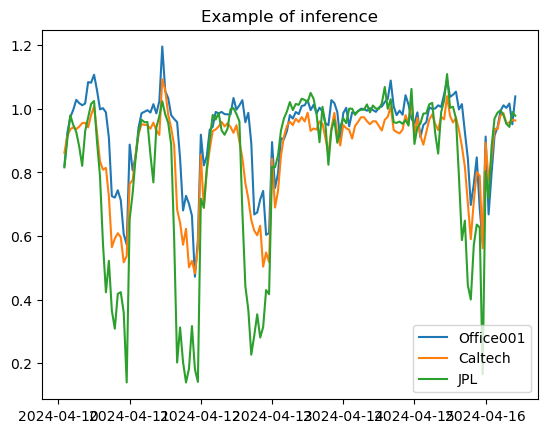

In [66]:
for site in sites:
    pred = model.predict(tmp[tmp['site']==site])
    plt.plot(tmp[tmp['site']==site].index, pred, label=site)
    
plt.title('Example of inference')
plt.legend()
